In [1]:
import pandas as pd
import numpy as np

from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from google.cloud import aiplatform
from vertexai.language_models import TextEmbeddingModel

aiplatform.init(
    project='vidio-quiz-prod',
    location='asia-southeast1',
    staging_bucket='gs://genai_hackathon_2024',
)

In [2]:
model = TextEmbeddingModel.from_pretrained("textembedding-gecko-multilingual")

def embedding_text(model, text):
    embeddings = model.get_embeddings([text])
    for embedding in embeddings:
        vector = embedding.values
        # print(f"Length of Embedding Vector: {len(vector)}")
    return vector

In [10]:
film_df = pd.read_json('film_metadata.json', lines=True)
print(film_df.head(1).actors.values)

['abdurrahman arif, andri mashadi, budi ros, dian sastrowardoyo, donny damara, hana malasan, ira wibowo, khiva iskak, muhammad khan, nino fernandez']


In [11]:
film_df['label'] = film_df['title'].apply(lambda x: x if x == 'ratu adil' else '')
film_df = film_df._append({"label": 'query dian sastrowardoyo', "search_text": "dian sastrowardoyo", "embedding": embedding_text(model, "dian sastrowardoyo")}, ignore_index=True)
film_df = film_df._append({"label": 'query dian sastro', "search_text": "dian sastro", "embedding": embedding_text(model, "dian sastro")}, ignore_index=True)
film_df = film_df._append({"label": 'query actors dian sastro', "search_text": "dian sastro", "embedding": embedding_text(model, "actors: dian sastro")}, ignore_index=True)
film_df = film_df._append({"label": 'query ratu adil', "search_text": "ratu adil", "embedding": embedding_text(model, "ratu adil")}, ignore_index=True)
film_df = film_df._append({"label": 'query actors ratu adil', "search_text": "abdurrahman arif, andri mashadi, budi ros, dian sastrowardoyo, donny damara, hana malasan, ira wibowo, khiva iskak, muhammad khan, nino fernandez", "embedding": embedding_text(model, "abdurrahman arif, andri mashadi, budi ros, dian sastrowardoyo, donny damara, hana malasan, ira wibowo, khiva iskak, muhammad khan, nino fernandez")}, ignore_index=True)

In [12]:
X = np.array(film_df['embedding'].to_list(), dtype=np.float32)
X.shape

(5776, 768)

In [13]:
tsne = TSNE(random_state=0, n_iter=1000)
tsne_results = tsne.fit_transform(X)

In [14]:
df_tsne = pd.DataFrame(tsne_results, columns=['TSNE1', 'TSNE2'])
df_tsne['title'] = film_df['title']
df_tsne['id'] = film_df['id']
df_tsne['popularity'] = film_df['popularity']
df_tsne['age_rating'] = film_df['age_rating']
df_tsne['group_l1'] = film_df['group_l1']
df_tsne['group_l2'] = film_df['group_l2']
df_tsne['label'] = film_df['label']
df_tsne

,TSNE1,TSNE2,title,id,popularity,age_rating,group_l1,group_l2,label
0,2.799385,9.560459,ratu adil,9372.0,trending,18 or more,series,vidio original,ratu adil
1,3.063941,9.160594,cinta pertama ayah,9456.0,trending,18 or more,series,vidio original,
2,-5.553125,-6.719742,bidadari surgamu,7617.0,trending,13 or more,series,tv sinetron,
3,-9.412822,-41.845745,magic 5,7576.0,trending,13 or more,series,tv sinetron,
4,-7.619321,-0.869041,tertawan hati,9535.0,trending,13 or more,series,tv sinetron,
...,...,...,...,...,...,...,...,...,...
5771,-29.240559,-45.455059,NaN,NaN,NaN,NaN,NaN,NaN,query dian sastrowardoyo
5772,-29.239906,-45.457176,NaN,NaN,NaN,NaN,NaN,NaN,query dian sastro
5773,-29.240450,-45.457951,NaN,NaN,NaN,NaN,NaN,NaN,query actors dian sastro
5774,5.900157,-11.868187,NaN,NaN,NaN,NaN,NaN,NaN,query ratu adil


In [15]:
df_tsne[df_tsne['label'] != '']

,TSNE1,TSNE2,title,id,popularity,age_rating,group_l1,group_l2,label
0,2.799385,9.560459,ratu adil,9372.0,trending,18 or more,series,vidio original,ratu adil
5771,-29.240559,-45.455059,NaN,NaN,NaN,NaN,NaN,NaN,query dian sastrowardoyo
5772,-29.239906,-45.457176,NaN,NaN,NaN,NaN,NaN,NaN,query dian sastro
5773,-29.240450,-45.457951,NaN,NaN,NaN,NaN,NaN,NaN,query actors dian sastro
5774,5.900157,-11.868187,NaN,NaN,NaN,NaN,NaN,NaN,query ratu adil
5775,-2.447631,-30.117205,NaN,NaN,NaN,NaN,NaN,NaN,query actors ratu adil


(-69.03179779052735, 80.16305389404297, -74.42580528259278, 71.76112480163575)

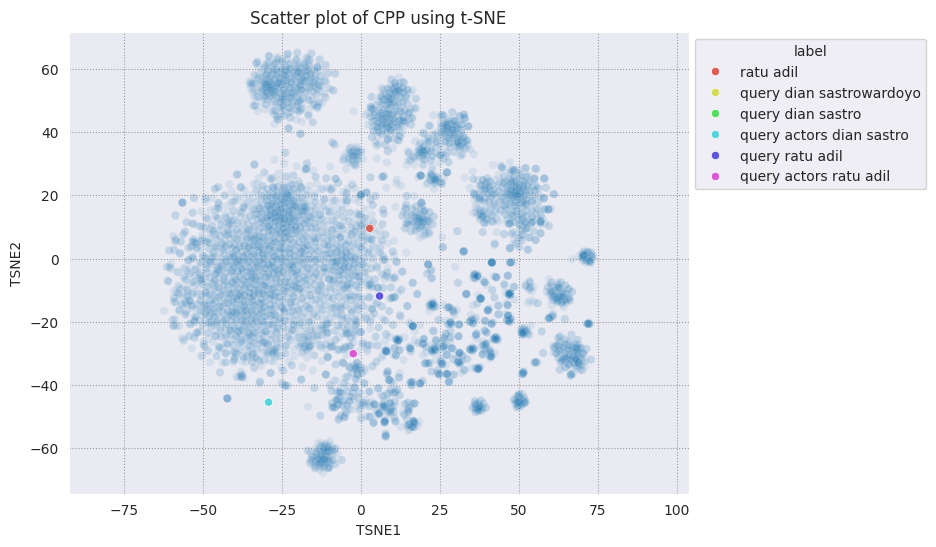

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(8,6)) # Set figsize
sns.set_style('darkgrid', {"grid.color": ".6", "grid.linestyle": ":"})
sns.scatterplot(data=df_tsne[df_tsne['label'] == ""], x='TSNE1', y='TSNE2', hue="label", alpha=0.1)
sns.scatterplot(data=df_tsne[df_tsne['label'] != ""], x='TSNE1', y='TSNE2', hue="label", palette='hls')
# sns.scatterplot(data=df_tsne[df_tsne['group_l2'] != "vidio original"], x='TSNE1', y='TSNE2', hue="group_l2", alpha=0.1)
# sns.scatterplot(data=df_tsne[df_tsne['group_l2'] == "vidio original"], x='TSNE1', y='TSNE2', hue="group_l2", palette='hls')
# sns.scatterplot(data=df_tsne[df_tsne['popularity'] == "trending"], x='TSNE1', y='TSNE2', hue="popularity")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title('Scatter plot of CPP using t-SNE');
plt.xlabel('TSNE1');
plt.ylabel('TSNE2');
plt.axis('equal')